# Modelo de Red Neuronal para clasificacion de vinos

In [1]:
# para leer el dataset wine.data
from pandas import read_csv
# funciones utiles de numpy
from numpy import unique, random, ravel, mean, std, zeros, random
# para generar arreglos aleatorios
from random import sample
# para dividir el conjunto de datos en 2 subconjuntos: uno de entrenamiento y otro de evaluacion
from sklearn.model_selection import train_test_split
# para standarizar (x-mu)/sigma los datos
from sklearn.preprocessing import StandardScaler
# para construir nuestros modelos
import keras
from keras import models
from keras.layers import Dense
from keras.initializers import RandomUniform
from keras.optimizers import Adam

# para k-fold cross validation
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping

# para elegir la tasa de aprendizaje mas optima
from keras import backend as K

# para graficar
from matplotlib.colors import CSS4_COLORS
import matplotlib.pyplot as plt

2023-04-17 15:26:53.069191: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 15:26:53.406177: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-17 15:26:53.458079: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-17 15:26:53.458097: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## Analizamos los datos

In [2]:
# importamos los datos (los datos estan separados por comas)
data = read_csv('./wine.data')
# mostramos las primeras 5 columnas
data.head()

,Wine,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280_of_diluted_wines,OD315_of_diluted_wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
# informacion del numero y tipo de datos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Wine                    178 non-null    int64  
 1   Malic_acid              178 non-null    float64
 2   Ash                     178 non-null    float64
 3   Alcalinity_of_ash       178 non-null    float64
 4   Magnesium               178 non-null    float64
 5   Total_phenols           178 non-null    int64  
 6   Flavanoids              178 non-null    float64
 7   Nonflavanoid_phenols    178 non-null    float64
 8   Proanthocyanins         178 non-null    float64
 9   Color_intensity         178 non-null    float64
 10  Hue                     178 non-null    float64
 11  OD280_of_diluted_wines  178 non-null    float64
 12  OD315_of_diluted_wines  178 non-null    float64
 13  Proline                 178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.

In [4]:
# informacion estadistica
data.describe()

,Wine,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280_of_diluted_wines,OD315_of_diluted_wines,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


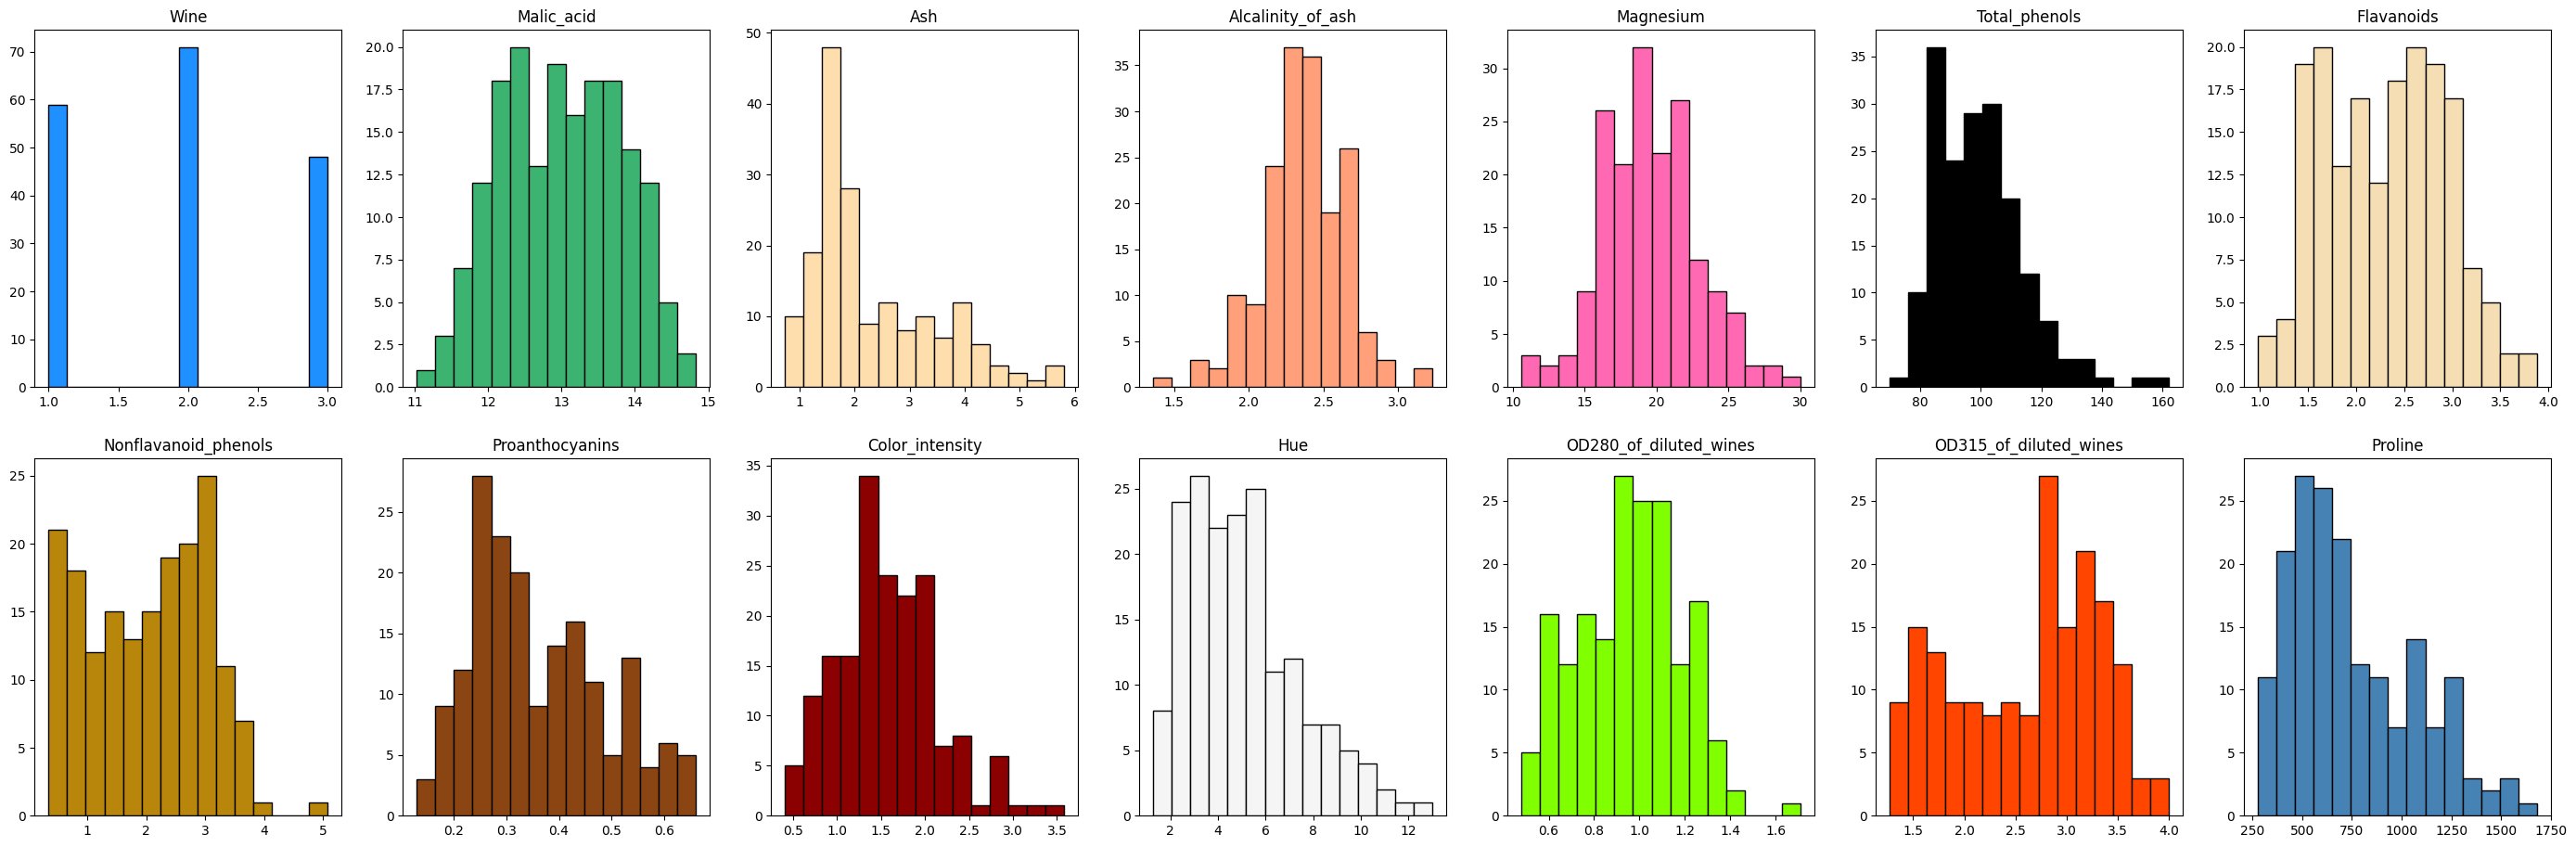

In [5]:
# graficamos los histogramas de los datos
num_features = len(data.columns)                        # numero de inputs
features     = data.columns                             # nombre asociado a los inputs
random.seed(42)                                         # fijamos una semilla
colors       = sample(list(CSS4_COLORS), num_features)  # arreglo de colores para los histogramas

# generamos los histogramas
fig, axes = plt.subplots(2, num_features//2, figsize=(5*num_features//2, 11))
for i, (feature, ax) in enumerate(zip(features, axes.flatten())):
    ax.hist(data[feature], bins=15, color=colors[i], ec='black')
    ax.set_title(feature)
plt.show()

## Split y standarizacion de los datos
Dividimos el dataset en los conjuntos de entrenamiento y evaluacion. Ademas, dado que el rango de valores de los datos no es homogeneo (algunas caracteristicas presentan valores pequenos mientras otras van hasta las centenas), debemos normalizar/standarizar los datos.

In [6]:
# dividimos el data set en dos conjuntos disjuntos: uno de entrenamiento y otro de evaluacion
train_ratio = 0.75      # razon de los datos empleados para el entrenamiento
train_data, test_data = train_test_split(data, train_size=train_ratio, random_state=42)

In [7]:
# imprimimos el numero de muestras en cada conjunto
print(f'Para entrenamiento se tienen {len(train_data)} muestras.')
print(f'Para evaluacion se tienen {len(test_data)} muestras.')

Para entrenamiento se tienen 133 muestras.
Para evaluacion se tienen 45 muestras.


In [8]:
# standarizamos o normalizamos los datos
scaler = StandardScaler()
train_data.iloc[:,1:] = scaler.fit_transform(train_data.iloc[:,1:])
test_data.iloc[:,1:] = scaler.transform(test_data.iloc[:,1:])

# tambien cambiamos los tipos de vinos de 1, 2, 3 a 0, 1, 2 (para que no haya conflictos con softmax)
train_data.iloc[:,0] = train_data.iloc[:,0] - 1
test_data.iloc[:,0]  = test_data.iloc[:,0] - 1

In [9]:
# separamos las etiquetas de los datos de entrada
train_labels, train_inputs = train_data.iloc[:,0].values, train_data.iloc[:,1:].values
test_labels, test_inputs = test_data.iloc[:,0].values, test_data.iloc[:,1:].values

## Primer modelo: Entrenamiento y evaluacion del performance en las predicciones

In [10]:
# definimos una funcion para construir un modelo
def construct_neural_network(model_info, input_shape, functions):
    '''
    Construye una red neuronal y la compila.
    Inputs:
        model_info (dict)   : incluye el numero de nodos (n_nodes) de cada capa asi como las funciones de activacion (activation).
        input_shape (tuple) : forma de la entrada (N_features, )
        functions (dict)    : incluye el initializer, optimizer, loss and metrics.
    Output:
        model: Red neuronal.
    '''
    # inicializamos el modelo
    model = models.Sequential()

    # definimos datos importantes del modelo
    n_nodes    = model_info['n_nodes']      # numero de nodos en cada capa
    activation = model_info['activation']   # funciones de activacion en cada capa

    # definimos algunas funciones importantes
    initializer = functions['initializer']
    optimizer   = functions['optimizer']
    loss        = functions['loss']
    metrics     = functions['metrics']

    # primera capa
    model.add(Dense(units = n_nodes[0],
                    kernel_initializer = initializer,
                    bias_initializer = 'zeros',
                    activation = activation[0],
                    input_shape = input_shape))

    # capas ocultas
    for i, (n, act_fn) in enumerate(zip(n_nodes[1:], activation[1:])):
        model.add(Dense(units = n,
                        kernel_initializer = initializer,
                        bias_initializer = 'zeros',
                        activation = act_fn))

    # compilamos el modelo
    model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
    
    return model

In [11]:
# informacion general de los datos
n_output    = len(unique(data['Wine'].values))  # numero de salidas (3 en este caso)
input_shape = data.iloc[0,1:].values.shape      # forma de la entrada ((13,) en este caso)

In [12]:
# informacion especifica de un modelo propuesto
model1_info = {'n_nodes': [4, 8, n_output], 
               'activation': ['relu', 'relu', 'softmax']}
functions   = {'initializer': RandomUniform(minval=0., maxval=0.1, seed=42),
               'optimizer': Adam(learning_rate=0.001),
               'loss': 'sparse_categorical_crossentropy',
               'metrics': ['accuracy']}

In [13]:
# definimos un primer modelo
network1 = construct_neural_network(model1_info, input_shape, functions)

2023-04-17 15:26:57.146436: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-17 15:26:57.146673: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-17 15:26:57.146689: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hinostra): /proc/driver/nvidia/version does not exist
2023-04-17 15:26:57.147647: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
# resumen del primer modelo
network1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 56        
                                                                 
 dense_1 (Dense)             (None, 8)                 40        
                                                                 
 dense_2 (Dense)             (None, 3)                 27        
                                                                 
Total params: 123
Trainable params: 123
Non-trainable params: 0
_________________________________________________________________


In [15]:
# definimos algunos hyperparametros
hyperpars = {'n_epochs': 100,
             'batch_size': 32}

In [16]:
# entrenamos el modelo (considerando un subconjunto de validacion)
val_split = 0.1
history_model = network1.fit(train_inputs, train_labels, 
                             epochs=hyperpars['n_epochs'], batch_size=hyperpars['batch_size'],
                             validation_split=val_split, shuffle=True, verbose=0)

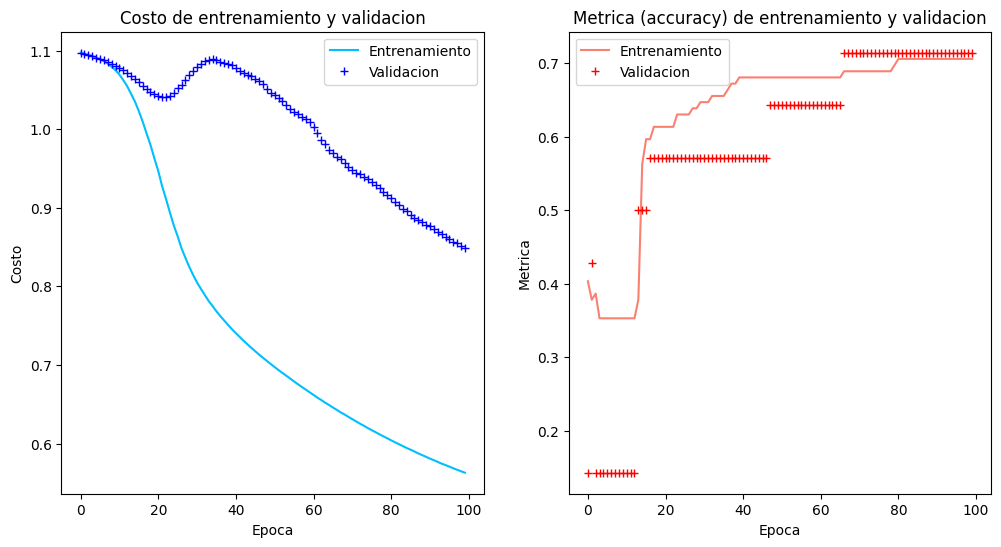

In [17]:
# Graficamos las curvas de aprendizaje y las graficas de precision (metrica)
# de los conjuntos de entrenamiento y validacion del modelo propuesto
train_loss = history_model.history['loss']
val_loss = history_model.history['val_loss']
train_acc = history_model.history['accuracy']
val_acc = history_model.history['val_accuracy']

# Graficamos el costo y accuracy para entrenamiento y validacion (todas las epocas)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(train_loss, c='deepskyblue', label='Entrenamiento')
ax1.plot(val_loss, 'b+', label='Validacion')
ax1.set_title('Costo de entrenamiento y validacion')
ax1.set_xlabel('Epoca')
ax1.set_ylabel('Costo')
ax1.legend()

ax2.plot(train_acc, c='salmon', label='Entrenamiento')
ax2.plot(val_acc, 'r+', label='Validacion')
ax2.set_title('Metrica (accuracy) de entrenamiento y validacion')
ax2.set_xlabel('Epoca')
ax2.set_ylabel('Metrica')
ax2.legend()

plt.show()

In [18]:
# evaluamos el modelo
test_loss, test_acc = network1.evaluate(test_inputs, test_labels)

2/2 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6889


Como notamos este modelo presenta overfitting y ademas no es muy preciso de acuerdo con la evaluacion del modelo. 

## Eleccion de hiperparametros
Primero vamos a optimizar la eleccion de hiperparametros (learning_rate, batch_size) para el modelo antes propuesto.

In [19]:
# construimos una funcion que devolvera el historial de entrenamiento de un modelo considerando
# diferentes hiperparametros, en particular consideraremos learning_rate y batch_size
def grid_search(model, train_inputs, train_labels, try_hyperpars, n_epochs, val_split):
    '''
    Similar a sklearn.model_selection.GridSearchCV. Realiza un recorrido sobre los hiperparametros
    learning_rate y batch_size para elegir los valores mas optimos.
    Inputs:
        model (Sequential)   : modelo al cual se quieren elegir los hiperparametros
        train_inputs (array) : datos de entrada para entrenamiento
        train_labels (array) : etiquetas para entrenamiento
        try_hyperpars (dict) : incluye listas de los valores de learning_rate y batch_size a emplear
        n_epochs (int)       : numero de epocas a entrenar
        val_split (float)    : razon de datos a emplear en la validacion
    Output:
        grid_list: lista de diccionarios con los historiales de entrenamiento empleando diferentes hiperparametros
    '''

    # inicializamos la lista de diccionarios 
    grid_list = []

    # iteramos sobre los posibles valores de learning_rate y batch_size
    for lr in try_hyperpars['learning_rate']:
        for bs in try_hyperpars['batch_size']:
            # se indica en el diccionario cuales son los valores de los hiperparametros
            try_dict = {'learning_rate': lr, 'batch_size': bs}

            # reinicializamos los pesos del modelo a valores aleatorios
            # para evitar overfitting en cada iteracion
            original_weights = model.get_weights()                                  # obtenemos los pesos
            new_weights = [random.normal(size=w.shape) for w in original_weights]   # generamos nuevos pesos aleatorios
            model.set_weights(new_weights)                                          # asignamos estos valores aleatorios a los pesos

            # asignamos el valor de la tasa de aprendizaje
            K.set_value(model.optimizer.learning_rate, lr)
            random.seed(42)
            # entrenamos el modelo con el tamano de batch indicado
            history_model = model.fit(train_inputs, train_labels, shuffle=True,
                                      epochs=n_epochs, batch_size=bs,
                                      validation_split=val_split, verbose=0)
            # guardamos el historial en el diccionario
            try_dict['history_model'] = history_model
            # anexamos este diccionario a la lista de diccionarios
            grid_list.append(try_dict)
            K.clear_session()
    return grid_list

In [20]:
# propuestas de hiperparametros
try_hyperpars = {'learning_rate': [0.1, 0.01, 0.001, 1e-4],
                 'batch_size': [16, 32, 64]}
# realizamos recorrido sobre los hiperparametros propuestos
grid1_list = grid_search(network1, train_inputs, train_labels, try_hyperpars, 250, 0.1)

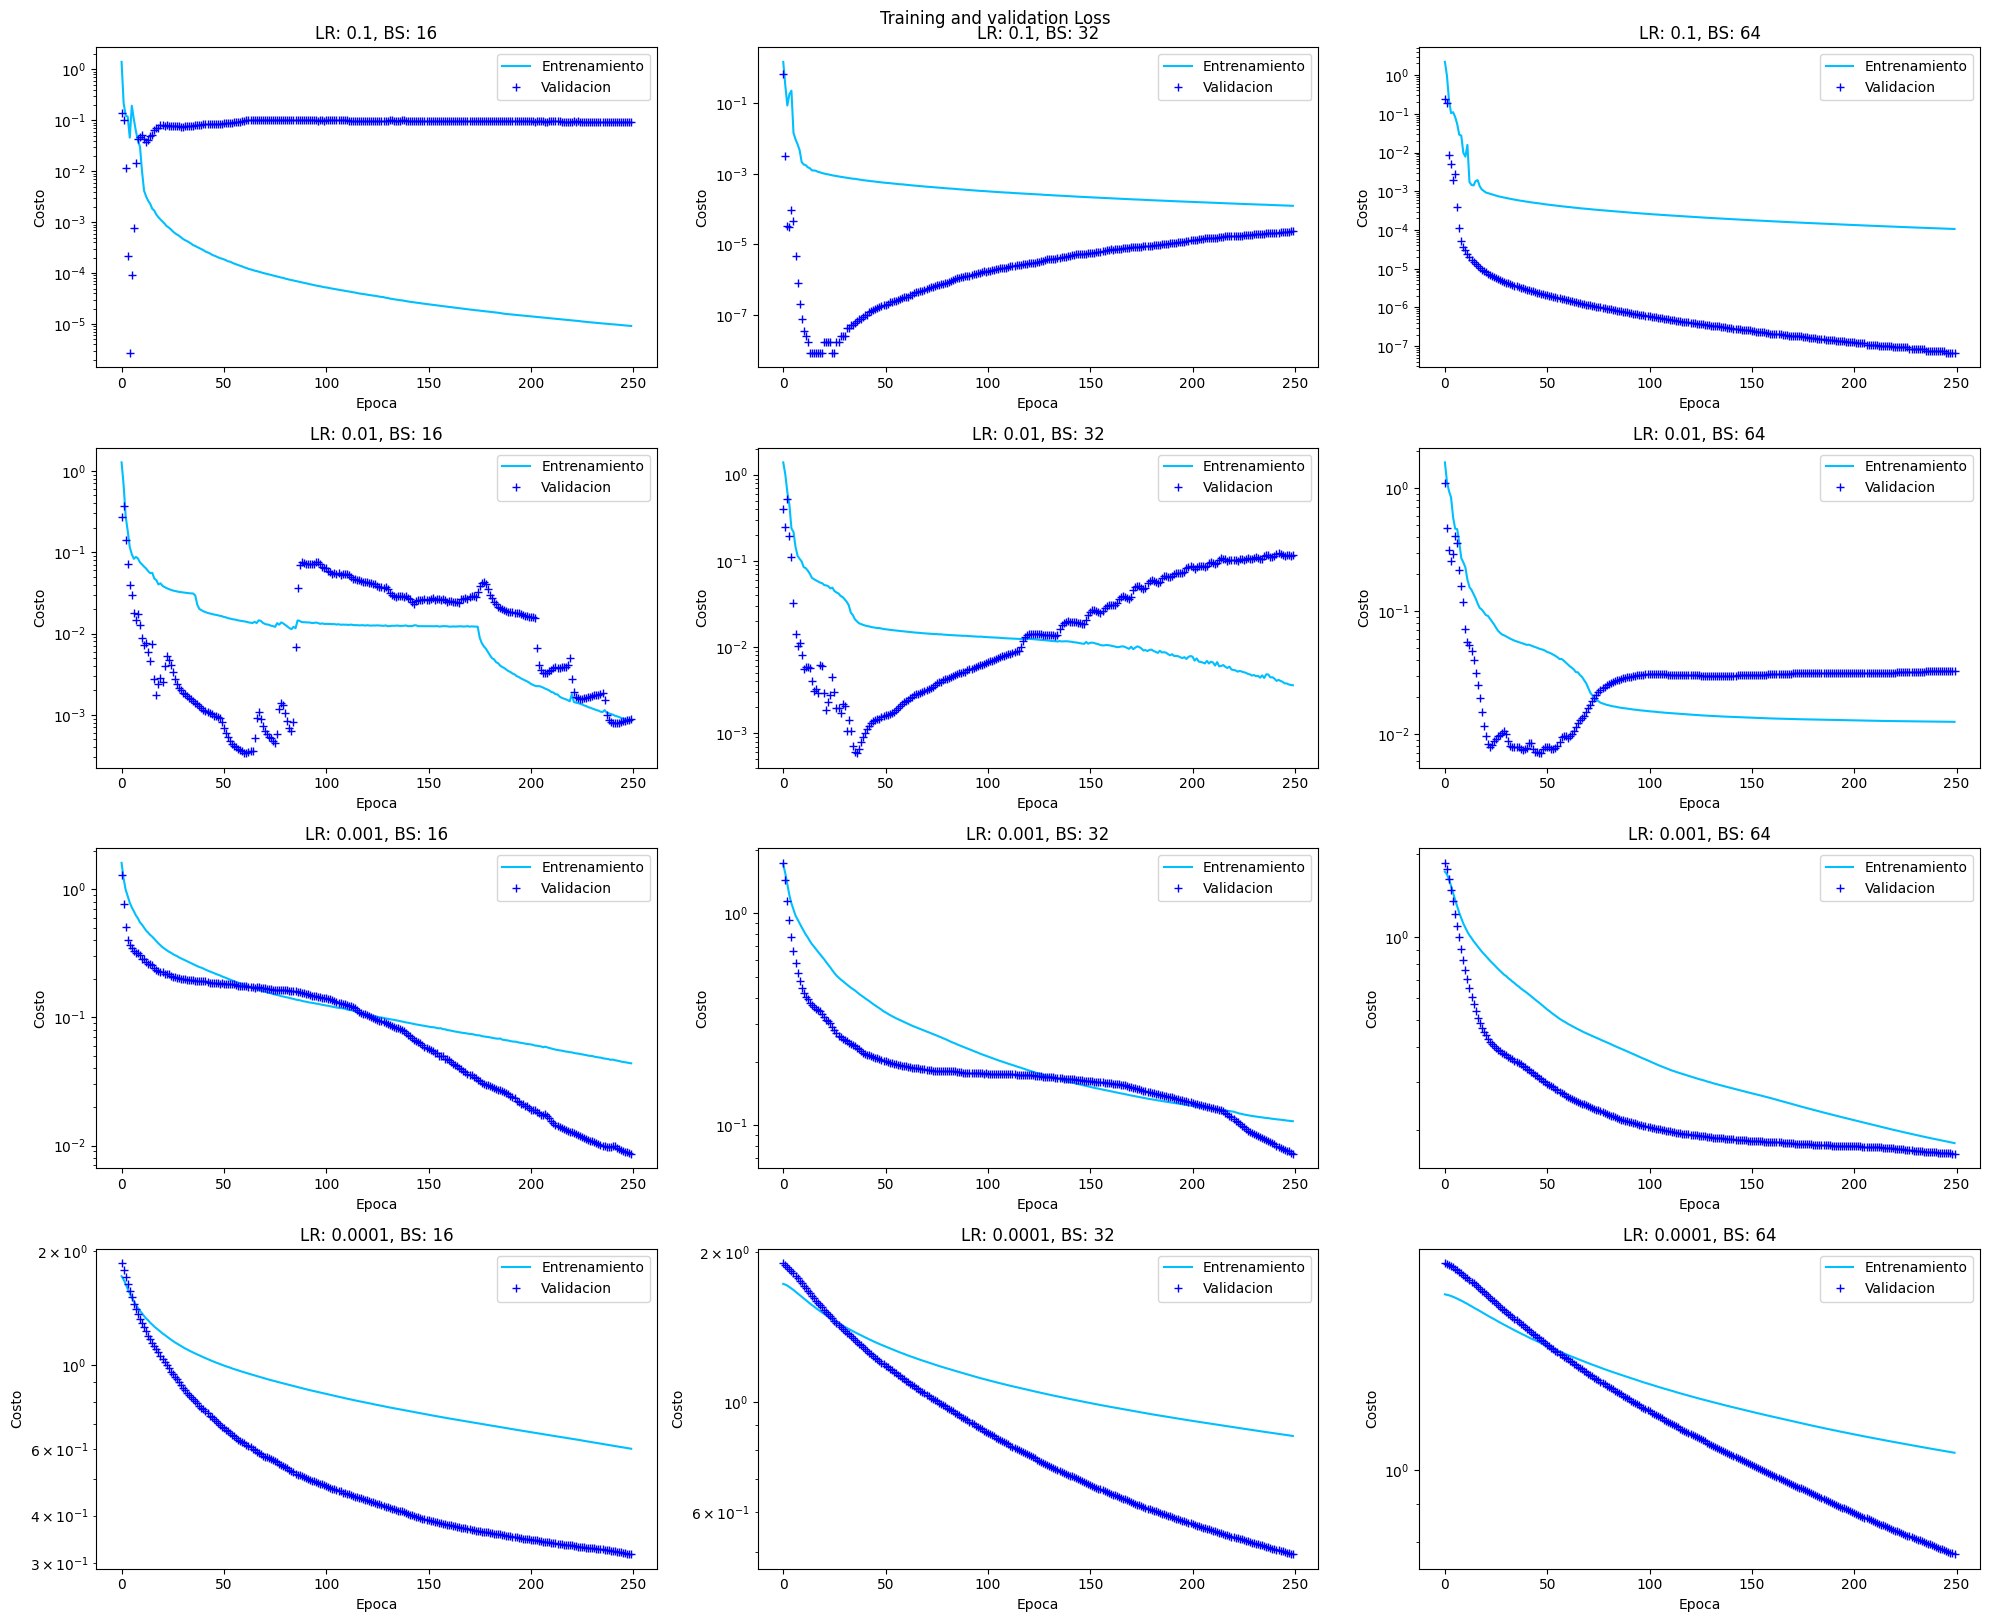

In [21]:
# graficamos las curvas de aprendizaje
num_lr, num_bs = len(try_hyperpars['learning_rate']), len(try_hyperpars['batch_size'])  # numero de hiperparametros considerados

fig, axes = plt.subplots(num_lr, num_bs, figsize=(5*num_lr, 5.5*num_bs))
for i, (try_dict, ax) in enumerate(zip(grid1_list, ravel(axes))):
    lr, bs = try_dict['learning_rate'], try_dict['batch_size']  # learning_rate y batch_size considerado

    history_model = try_dict['history_model']
    train_loss = history_model.history['loss']      # perdida del conjunto de entrenamiento
    val_loss = history_model.history['val_loss']    # perdida del conjunto de validacion

    ax.plot(train_loss, c='deepskyblue', label='Entrenamiento')
    ax.plot(val_loss, 'b+', label='Validacion')
    ax.set_title('Costo de entrenamiento y validacion')
    ax.set_xlabel('Epoca')
    ax.set_ylabel('Costo')
    ax.set_yscale('log')
    ax.legend()
    ax.set_title(f'LR: {lr}, BS: {bs}')

plt.suptitle('Training and validation Loss')
plt.tight_layout()
plt.show()

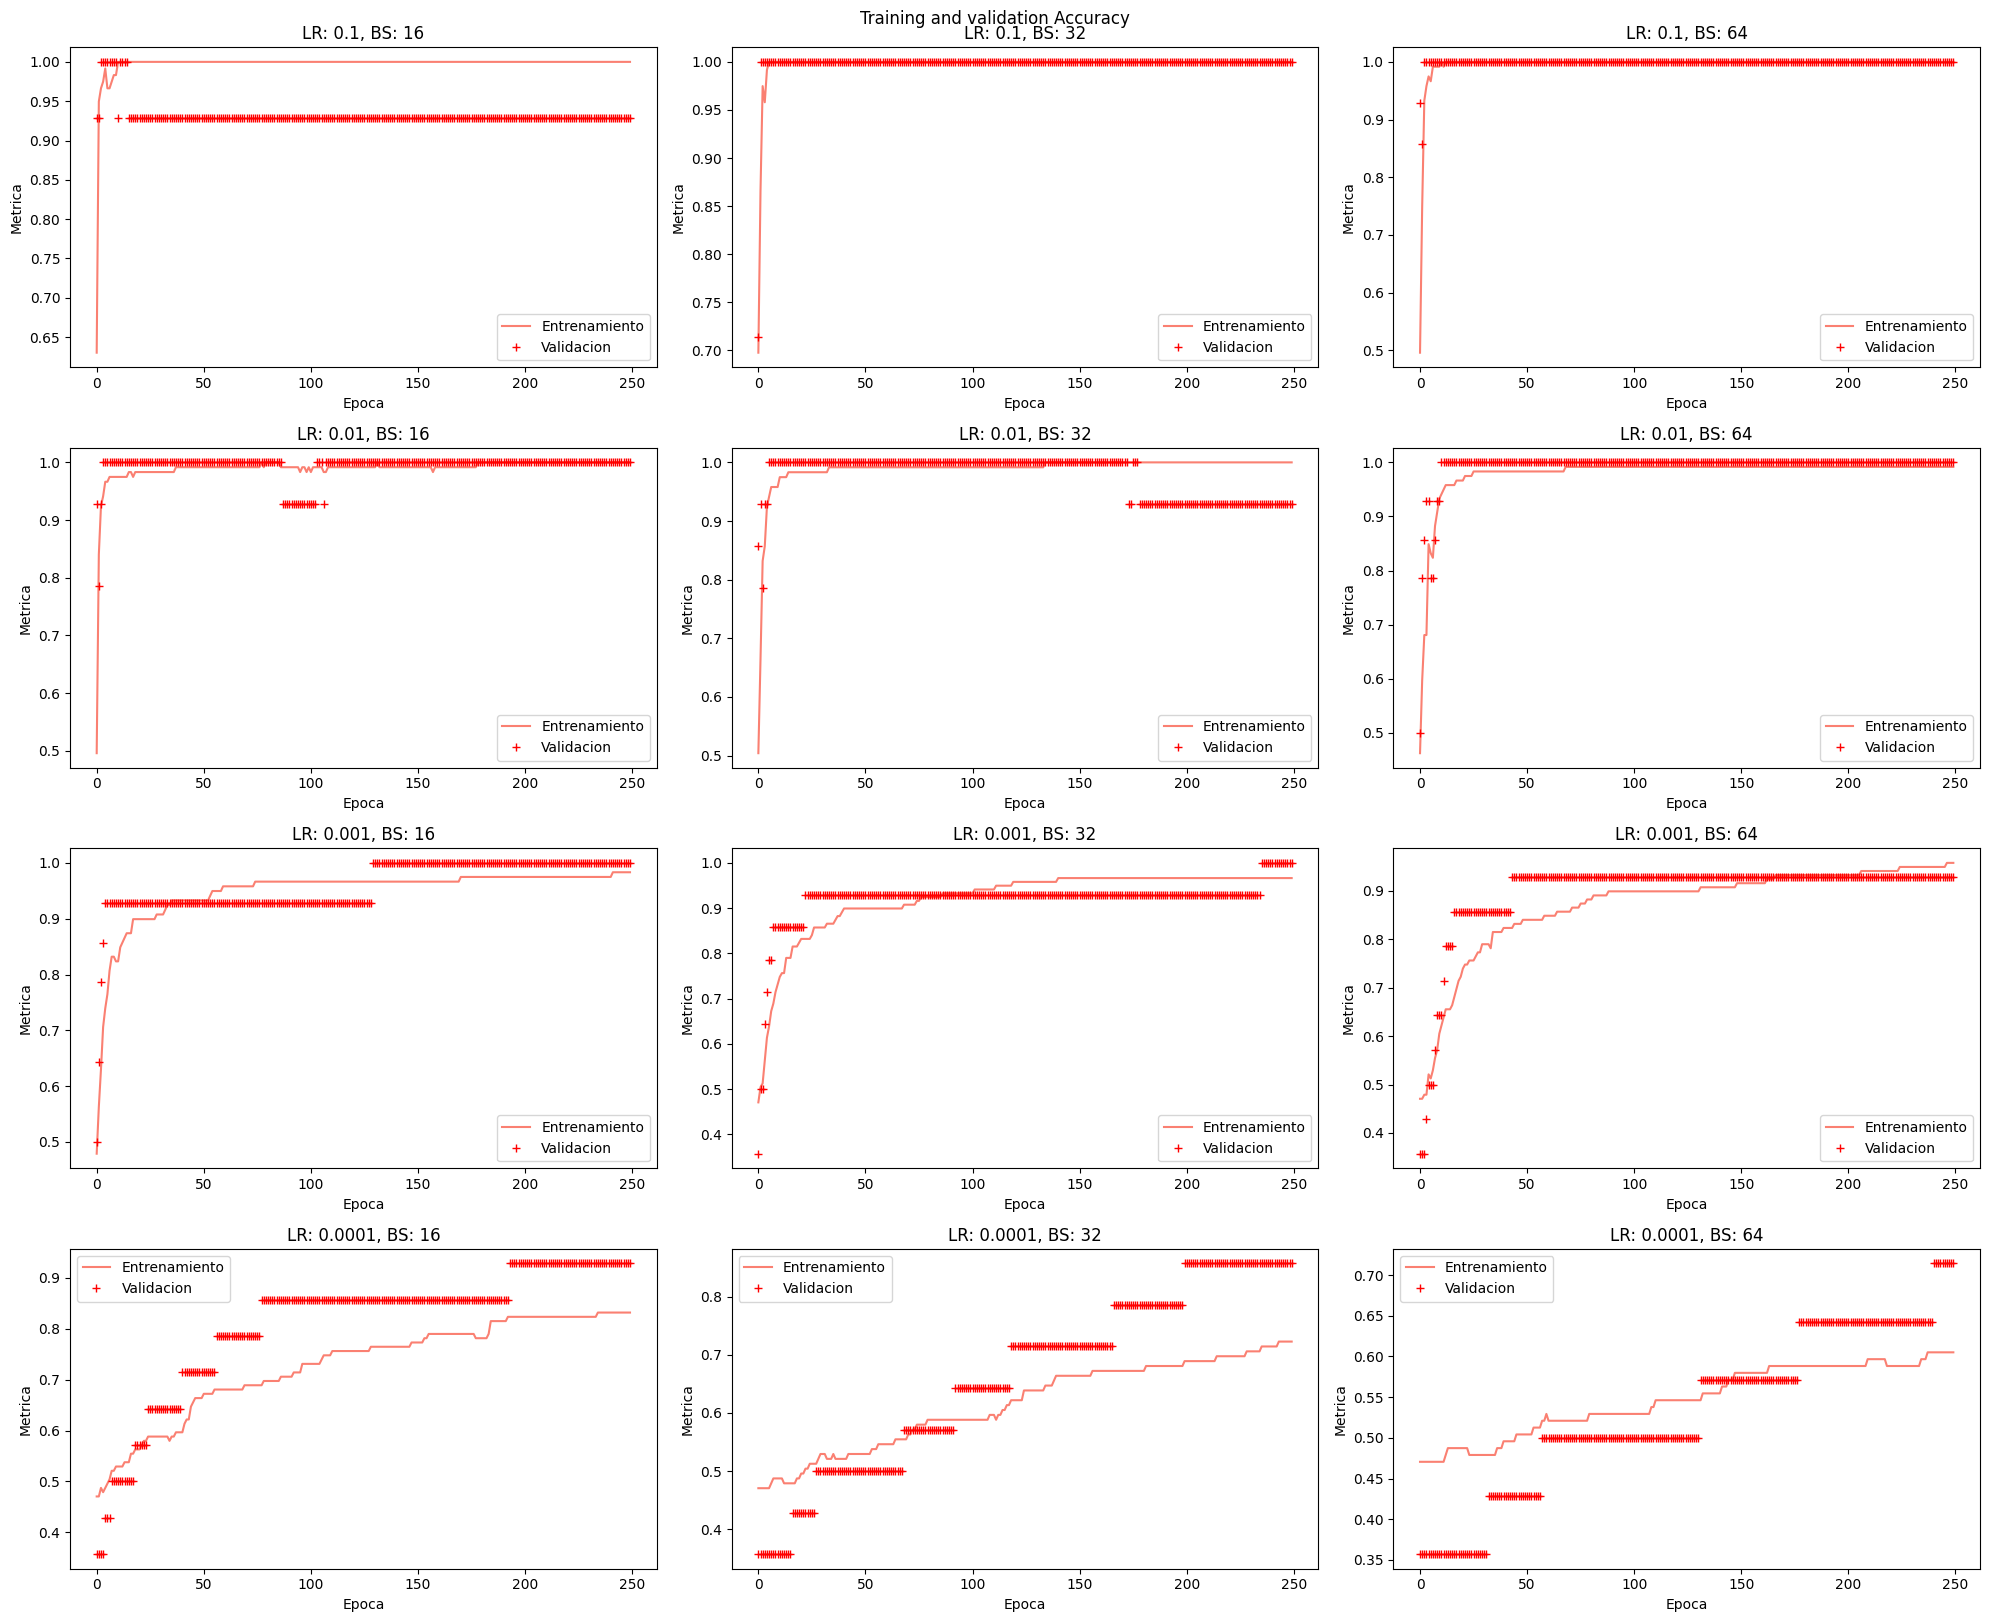

In [22]:
# graficamos la precision (metrica) para los diferentes hiperparametros
fig, axes = plt.subplots(num_lr, num_bs, figsize=(5*num_lr, 5.5*num_bs))
for i, (try_dict, ax) in enumerate(zip(grid1_list, ravel(axes))):
    lr, bs = try_dict['learning_rate'], try_dict['batch_size']

    history_model = try_dict['history_model']
    train_acc = history_model.history['accuracy']       # metrica del conjunto de entrenamiento
    val_acc = history_model.history['val_accuracy']     # metrica del conjunto de validacion

    ax.plot(train_acc, c='salmon', label='Entrenamiento')
    ax.plot(val_acc, 'r+', label='Validacion')
    ax.set_title('Metrica (accuracy) de entrenamiento y validacion')
    ax.set_xlabel('Epoca')
    ax.set_ylabel('Metrica')
    ax.legend()
    ax.set_title(f'LR: {lr}, BS: {bs}')

plt.suptitle('Training and validation Accuracy')
plt.tight_layout()
plt.show()

Como notamos, para tazas de aprendizaje grandes (0.1) las curvas de aprendizaje (cyan solido) y de la perdida de validacion (azul +) presentan ligeras oscilaciones. Ademas, si la taza de aprendizaje es muy pequena (0.0001) notamos que no se alcanza el minimo de la funcion de costo. Considerando ambas graficas (las curvas de aprendizaje y la curva de accuracy) escogemos un **learning_rate = 0.01** y un **batch_size = 16**. Ademas reducimos el numero de epocas a considerar (para evitar el overfitting que ya se observa desde 170 epocas).

In [23]:
# hiperparametros seleccionados
learning_rate = 0.01
batch_size    = 16

## Comparamos con otros modelos mas simples o mas complejos
Considerando los hiperparametros anteriores, propondremos 4 modelos y compararemos sus performances al predecir el tipo de vino. Considerando que tenemos pocos datos, realizaremos k-fold cross validation para analizar adecuadamente la eficacia del modelo.

In [24]:
# definicion de nuevos modelos para clasificar vinos
functions   = {'initializer': RandomUniform(minval=0., maxval=0.1, seed=42),
               'optimizer': Adam(learning_rate=learning_rate),
               'loss': 'sparse_categorical_crossentropy',
               'metrics': ['accuracy']}

model1_info = {'n_nodes': [4, 8, n_output], 
               'activation': ['relu', 'relu', 'softmax']}
network1 = construct_neural_network(model1_info, input_shape, functions)    # modelo antes implementado 

model2_info = {'n_nodes': [6, n_output], 
               'activation': ['relu', 'softmax']}
network2 = construct_neural_network(model2_info, input_shape, functions)    # modelo mas simple

model3_info = {'n_nodes': [2, 6, 5, n_output], 
               'activation': ['relu', 'relu', 'relu', 'softmax']}
network3 = construct_neural_network(model3_info, input_shape, functions)    # modelo mas complejo

model4_info = {'n_nodes': [7, 15, 8, 6, n_output], 
               'activation': ['relu', 'relu', 'relu', 'relu', 'softmax']}
network4 = construct_neural_network(model4_info, input_shape, functions)    # modelo mucho mas complejo

networks = [network1, network2, network3, network4]

In [25]:
# k-fold cross validation para estos modelos con pocos datos de entrada
def k_fold_cross_validation(model, x, y, k=10, epochs=100, batch_size=batch_size, save_hist=False, verbose=0):
    '''
    k-fold cross validation.
    Inputs:
        model (Sequential)  : red neuronal
        x (array)           : datos de entrada
        y (array)           : etiquetas
        k (int)             : numero de folds a emplear
        epochs (int)        : numero de epocas de entrenamiento
        batch_size (int)    : tamano de mini-batches
        save_hist (bool)    : si guardar o retornar el historial de entrenamiento
        verbose (int)       : argumento de fit para imprimir resultados
    Output:
        train_dict, val_dict: diccionarios con los valores de perdida y metrica para cada fold
    '''

    # definimos el kfold cross validator (nos permitira obtener indices aleatorios para dividir el conjunto de entrenamiento)
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold = 0    # contador
    scores = []     # lista para guardar valores de metrica
    if save_hist:
        train_dict, val_dict = {'train_loss': [], 'train_acc': []}, {'val_loss': [], 'val_acc': []} # diccionarios de salida

    # Iteramos sobre cada fold
    for train_index, test_index in kf.split(x):
        # reinicializamos los pesos a valores aleatorios
        original_weights = model.get_weights()
        new_weights = [random.normal(size=w.shape) for w in original_weights]
        model.set_weights(new_weights)

        # dividimos el dataset en un conjunto de entrenamiento y otro de validacion
        x_train, x_val = x[train_index], x[test_index]
        y_train, y_val = y[train_index], y[test_index]

        # definimos un callback para obtener el mejor modelo en cada fold (evitando overfitting por exceso de epocas de entrenamiento)
        earlystop_callback = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto', restore_best_weights=True)

        # entrenamos el modelo
        history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), callbacks=[earlystop_callback], verbose=0)
        
        # evaluamos el modelo en el conjunto de validacion y guardamos los valores de [loss, accuracy]
        score = model.evaluate(x_val, y_val, verbose=0)

        if save_hist:
            train_dict['train_loss'].append(history.history['loss'])
            val_dict['val_loss'].append(history.history['val_loss'])
            train_dict['train_acc'].append(history.history['accuracy'])
            val_dict['val_acc'].append(history.history['val_accuracy'])

        # imprimimos resultados por cada fold (opcional)
        if verbose:
            fold += 1
            print('Fold {}/{}'.format(fold, k))
            print('Validation loss: {:.4f} / Validation accuracy: {:.4f}'.format(score[0], score[1]))
        scores.append(score[1])
    
    # calculamos e imprimimos la metrica resultante de todos los fold
    print('Average accuracy: {:.4f} (+/- {:.4f})'.format(mean(scores), std(scores)))
    if save_hist:
        return train_dict, val_dict

In [26]:
# entrenamos y evaluamos sobre los modelos propuestos
test_losses, test_accs = [], []

for i, network in enumerate(networks):
    print(f'Model {i+1}')
    k_fold_cross_validation(network, train_inputs, train_labels)
    _test_loss, _test_acc = network.evaluate(test_inputs, test_labels)
    test_losses.append(_test_loss)
    test_accs.append(_test_acc)

Model 1
Average accuracy: 0.9484 (+/- 0.0734)
2/2 [==============================] - 0s 3ms/step - loss: 0.2345 - accuracy: 0.9333
Model 2
Average accuracy: 0.9341 (+/- 0.0901)
2/2 [==============================] - 0s 2ms/step - loss: 0.2035 - accuracy: 0.9111
Model 3
Average accuracy: 0.7324 (+/- 0.2328)
2/2 [==============================] - 0s 2ms/step - loss: 0.7097 - accuracy: 0.8667
Model 4
Average accuracy: 0.7676 (+/- 0.1815)
2/2 [==============================] - 0s 2ms/step - loss: 0.6418 - accuracy: 0.6222


Notamos que el primer modelo (con dos capas ocultas) y el modelo 2 (el mas simple con solo una capa oculta) son los que presentan mejor precision. Podemos afirmar que para este dataset, los modelos mas simples son mas efectivos que los modelos mas complejos (como los dos ultimos) para clasificar tipos de vino. Ademas dado que el primero presenta una mayor precision de los valores de accuracy, podriamos tomar este como nuestro mejor modelo. Tengamos en cuenta que los hiperaparametros (como el numero de folds para el cross-validation, el learning_rate y el batch_size) se eligio como el mismo para todos los modelos, asi que podria darse que personalizando la eleccion de hiperparametros para cada modelo, se obtenga un mejor resultado para cada modelo.

Para culminar, probemos cambiando otro hiperparametro:
### Numero de nodos para un modelo con una sola capa oculta
Consideramos una sola capa oculta dado que este tipo de arquitectura presento un alto valor de accuracy y una menor dispersion entre los valores de accuracy en el k-fold cross-validation. Probaremos con un numero de neuronas que va desde 1 hasta 15 neuronas (con ReLU como funcion de activacion).

In [33]:
# funciones por defecto
functions   = {'initializer': RandomUniform(minval=0., maxval=0.1, seed=42),
               'optimizer': Adam(learning_rate=learning_rate),
               'loss': 'sparse_categorical_crossentropy',
               'metrics': ['accuracy']}

# almacenamos el costo y precision de los modelos propuestos
test_losses, test_accs = [], []

for n in range(1, 31):
    model_info = {'n_nodes': [n, n_output], 
               'activation': ['relu', 'softmax']}
    network = construct_neural_network(model_info, input_shape, functions)    # modelo mas simple

    print(f'Una capa oculta con {n} neuronas:')
    k_fold_cross_validation(network, train_inputs, train_labels)
    _test_loss, _test_acc = network.evaluate(test_inputs, test_labels, verbose=0)
    print('Test loss: {:.4f}, Test accuracy: {:.4f}'.format(_test_loss,_test_acc))
    test_losses.append(_test_loss)
    test_accs.append(_test_acc)

Una capa oculta con 1 neuronas:
Average accuracy: 0.6907 (+/- 0.0672)
Test loss: 0.4384, Test accuracy: 0.7333
Una capa oculta con 2 neuronas:
Average accuracy: 0.9335 (+/- 0.0610)
Test loss: 0.0220, Test accuracy: 1.0000
Una capa oculta con 3 neuronas:
Average accuracy: 0.9566 (+/- 0.0574)
Test loss: 0.0991, Test accuracy: 0.9778
Una capa oculta con 4 neuronas:
Average accuracy: 0.9341 (+/- 0.0874)
Test loss: 0.0554, Test accuracy: 0.9778
Una capa oculta con 5 neuronas:
Average accuracy: 0.9780 (+/- 0.0336)
Test loss: 0.1497, Test accuracy: 0.9333
Una capa oculta con 6 neuronas:
Average accuracy: 0.9330 (+/- 0.0391)
Test loss: 0.2476, Test accuracy: 0.8889
Una capa oculta con 7 neuronas:
Average accuracy: 0.9929 (+/- 0.0214)
Test loss: 0.0300, Test accuracy: 1.0000
Una capa oculta con 8 neuronas:
Average accuracy: 0.9484 (+/- 0.0649)
Test loss: 0.0890, Test accuracy: 0.9778
Una capa oculta con 9 neuronas:
Average accuracy: 0.9698 (+/- 0.0506)
Test loss: 0.0386, Test accuracy: 0.9778
U

Se consigue un minimo de perdida de 0.015181098133325577 con 26 neuronas


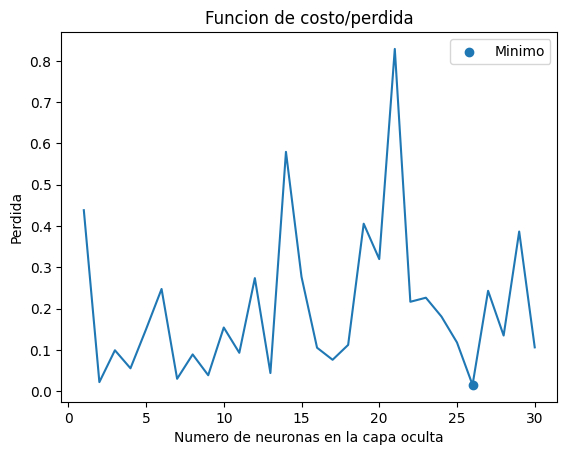

In [37]:
min_value = min(test_losses)
min_index = test_losses.index(min_value)

print(f'Se consigue un minimo de perdida de {min_value} con {min_index + 1} neuronas')

plt.plot(range(1,31), test_losses)
plt.scatter(min_index + 1, min_value, label='Minimo')
plt.title('Funcion de costo/perdida')
plt.xlabel('Numero de neuronas en la capa oculta')
plt.ylabel('Perdida')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Se consigue un maximo de accuracy de 1.0 con 2 neuronas


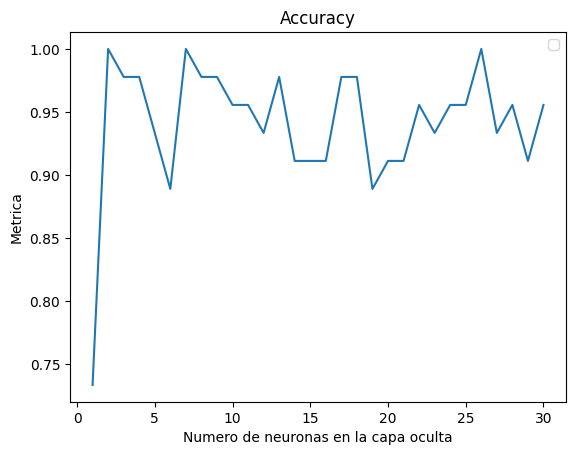

In [39]:
plt.plot(range(1,31), test_accs)
plt.title('Accuracy')
plt.xlabel('Numero de neuronas en la capa oculta')
plt.ylabel('Metrica')
plt.legend()
plt.show()

Notamos que, en general, emplear una capa oculta y mas de dos neuronas en dicha capa nos trae buenos resultados. No se observa un comportamiento en las curvas que nos indique si el incrementar o disminuir el numero de neuronas siempre nos permitira mejorar la eficiencia del modelo. Sin embargo, quizas sea mas eficiente usar arquitecturas de dos capas ocultas en lugar de una capa oculta con un gran numero de neuronas. Por lo general, usar entre 2-10 neuronas en una capa oculta parece ser suficiente para obtener resultados satisfactorios.